In this note I apply machine learning techniques to make the computer in skyjo smarter. 

In this noteboook I use normal machine learning using properties of a turns against the result target (score/winner) of the round/game. 

In the application to the game the algorithm then tests the possible options (actions plus card choice if applied on open card) plus the unchangable players card, pile properties and uses the best one.

The current card values of closed (20) and existing (30) mean that linear methods do not work. I could have used card mean for closed and 0 for existing. That would get many of the effects but not all since the variance of the values matters and vanish is not exactly the same as zero. 
Instead I opt in the first attempt to use the non linear algorith xgboost because it is fast and can handle non linear effects.

While for the players card in most the game it does not matter where the cards are it matters for whether the player can reduce his score by making three equal cards vanish in a row. For now I try brute force instead of having a scheme where that is more directly recorded.

First I import the needed modules. 

This notebook first mainly executes the best method from machine_learning_skyjo1 correcting the small problem found. 

In [1]:
#standard modukles
import numpy as np
import random as random
import time
import pandas as pd
#using simpleguitk for display, is not needed for computer game
#likely not needed un this notebook 
import simpleguitk as simplegui
#foor plotting 
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
#for efficient saving and loading
import pickle
#skyjp game classes and functions
from skyjo_functions2 import *
#own functions for machine learning
from ml_functions1 import *
#for machine learning
from xgboost import XGBRegressor

First I test whether a single round works. 

In [2]:
#needs the player defined
names=['alpha','beta']
nature=['computer','computer']
levels=[0,0]
scores,turns,last_player,numeric=skyjo_round(names,nature,levels,0,True,True,True) 

In works.


For now I work with two players, because it is likely easiest. Secondly, I work on a round, not a match, because while the game is the principal unit, it include some additional complications, but it seems unlikely that they influence the strategy much or at all. 

As the first step I train a predictor to predict the point differential (own points-opponents points).  I use only a subset of the feature information now. I ignore most information of the piles, besides the top most open card, which can be taken. The other information (mainly values of other played cards) is in principle useful to know which cards are still in game, but that should be a minor modification of the main strategy.  The length of the closed pile, is also related to it and is likely just a shortcut it should be possible to get it from other properties also. 
I also ignore whether cards vanish because it depends on the value of closed cards and cannot none so well as the algorithm could think when it uses all data. Also it is likely just a minor modification, although it is possible that it nt easy to find because it rather differnt form the used options. Later I will reconsider this point. 

I also ignore the round number since I expect that it is not useful at least when all player card value and the open card value is available.

I implement these choices below in an 1D arrayb with the number of columns, 1 are the used columns, 0 are not used columns.  I also create a string list, such that the collected data can be passed to a table with meaningful column names. 

In [9]:
names=['alpha','beta']
nature=['computer','computer']
levels=[0,0]
scores,turns,last_player,numeric=skyjo_round(names,nature,levels,0,True,True,True) 
print(numeric.shape)
#selected rows array
sel1=np.zeros((51))
#print the row to see whether it is what it should be 
#open card on pile
sel1[1]=1
#own card set
print(numeric[18:30,0])
sel1[18:30]=1
#other card set
print(numeric[30:42,0])
sel1[30:42]=1
#take open 
print(numeric[42])
sel1[42]=1
#discard
print(numeric[43])
sel1[43]=1
# discarded closed card
print(numeric[44])
sel1[44]=1
#id of selected player card
print(numeric[45])
sel1[45]=1
#numeric (number of open or 20 for closed) of selected player card
print(numeric[46])
sel1[46]=1
#score, differential is used as target for now both included in collection
print(numeric[49])
sel1[49]=1
print(numeric[50])
sel1[50]=1
print(sum(sel1))
print(numeric.shape)
# list of strings which will be pandas header
columns=['open_pile_card']
for i in range(12):
    columns.append('own_cards_'+str(i))
for i in range(12):
    columns.append('other_player_cards_'+str(i))    
columns.append('action_take_open')
columns.append('action_discard')
columns.append('discard_value')
columns.append('id_player_card')
columns.append('numeric_player_card')            
columns.append('score_self')
columns.append('score_other')
columns.append('round')
print(columns)
print(len(columns))
#create copy which to be used fields  score not
sel2=np.copy(sel1)
sel2[48:51]=0
np.savetxt("xgb_model1_column2.txt",sel2)
print(sum(sel2))
print(sum(sel1))
print(sel2)
print(sel1)
print(columns[0:30])

(51, 24)
[20 20 20 12 20 20 20  8 20 20 20 20]
[20 20 20  5 20 20 20  0 20 20 20 20]
[1 1 0 0 1 0 0 0 1 1 0 0 1 1 1 1 1 0 0 0 1 0 0 0]
[0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 1]
[30 30 11  2 30  9  3 11 30 30  7  0 30 30 30 30 30  4 10  3 30  4  7 12]
[ 2  3  0 10  6 11 10  3  9  3  4  0  1  5  5  1  0  8 11  2 11  4  8  9]
[20  5 20 20 20 20 20  1 20 11 20 20 20 20 20 20 11 20 20 20  5 20 20 20]
[56 81 56 81 56 81 56 81 56 81 56 81 56 81 56 81 56 81 56 81 56 81 56 81]
[81 56 81 56 81 56 81 56 81 56 81 56 81 56 81 56 81 56 81 56 81 56 81 56]
32.0
(51, 24)
['open_pile_card', 'own_cards_0', 'own_cards_1', 'own_cards_2', 'own_cards_3', 'own_cards_4', 'own_cards_5', 'own_cards_6', 'own_cards_7', 'own_cards_8', 'own_cards_9', 'own_cards_10', 'own_cards_11', 'other_player_cards_0', 'other_player_cards_1', 'other_player_cards_2', 'other_player_cards_3', 'other_player_cards_4', 'other_player_cards_5', 'other_player_cards_6', 'other_player_cards_7', 'other_player_cards_8', 'other_player_

Thus in total it are 31 features and 1 target. The target is currently still in two different columns. 

One round is clearly not enough to train, not only because of the length of here 32 data collections (turns), but also because the data is similar in the different turns. 
Thus, the data from many rounds needs to be collected. 


Below a check I check the function which collected many rounds.

In [4]:
start_time=time.time()
df=round_for_ml(names,nature,levels,sel1,3000,columns)
stop_time=time.time()
print(f"running time was {round(stop_time-start_time,4)} seconds")
print(df)

case 0
case 1000
case 2000
number of rows is 98039
running time was 17.8787 seconds
    open_pile_card  own_cards_0  own_cards_1  own_cards_2  own_cards_3  \
0                5           20           20           20           20   
1               -1           20           20           20            4   
2                8           20           20           20           20   
3                0           20           20           20            4   
4                4            8           20           20           20   
..             ...          ...          ...          ...          ...   
51               5            8            4            7            3   
52               5            3           20            1           20   
53               2            8            4            7            3   
54               2            3           20            1            8   
55              12            8            4            7            3   

    own_cards_4  own_cards_

That was just for checking whether it works, because using each turn is less efficient than using a subset.

Now I check below whether the splitting required for it still works.

In [31]:
df=pd.read_pickle('level0_10000.pkl')
feature_train,feature_test,feature_valid,target_train,target_test,target_valid=split_test(df.iloc[:,0:31],df.score_self-df.score_other,df.loc[:,'round'],0.5,0.8)
print(feature_train.shape,feature_test.shape,feature_valid.shape)

165074
165087
264118
264123
(165087, 31) (99036, 31) (66024, 31)


It works. 

Now  I am checking the other mode which only puts out one turn per game. This one is used. 

In [47]:
start_time=time.time()
df=round_for_ml_sel(names,nature,levels,sel1,3000,columns)
df.to_pickle('level_rand_v2_0_3000_0.pkl')
stop_time=time.time()
print(f"calculation needed {round(stop_time-start_time,4)} seconds")
print(df)

case 0
case 1000
case 2000
number of rows is 3000
calculation needed 5.0827 seconds
      open_pile_card  own_cards_0  own_cards_1  own_cards_2  own_cards_3  \
0                  4            7            1           -2            3   
1                 -1           10            4            1            5   
2                  9            8            5           10            3   
3                  6            9            0            4            9   
4                  0           10           20           -2            6   
...              ...          ...          ...          ...          ...   
2995              -1            0           20           20           20   
2996              11           20            5            8            9   
2997               4            1            6            8           11   
2998               5           20           10           20           20   
2999               7            1           20            1           20   

   

Works in the test case. 

I now test the split function for it. 

In [36]:
feature_train,feature_test,feature_valid,target_train,target_test,target_valid=split_test(df.iloc[:,0:31],df.score_self-df.score_other,df.loc[:,'round'],0.5,0.8)
print(feature_train.shape,feature_test.shape,target_test.shape)

1500
1500
2400
2400
(1500, 31) (900, 31) (900,)


Now I am generating 3 million rows of data in pieces of 0.6 million rows since that is easily possible at once. 

In [54]:
start_time=time.time()
df=round_for_ml_sel(names,nature,levels,sel1,600000,columns)
df.to_pickle('level_rand_v2_0_600000_4.pkl')
stop_time=time.time()
print(f"calculation needed {round(stop_time-start_time,4)} seconds")

case 0
case 1000
case 2000
case 3000
case 4000
case 5000
case 6000
case 7000
case 8000
case 9000
case 10000
case 11000
case 12000
case 13000
case 14000
case 15000
case 16000
case 17000
case 18000
case 19000
case 20000
case 21000
case 22000
case 23000
case 24000
case 25000
case 26000
case 27000
case 28000
case 29000
case 30000
case 31000
case 32000
case 33000
case 34000
case 35000
case 36000
case 37000
case 38000
case 39000
case 40000
case 41000
case 42000
case 43000
case 44000
case 45000
case 46000
case 47000
case 48000
case 49000
case 50000
case 51000
case 52000
case 53000
case 54000
case 55000
case 56000
case 57000
case 58000
case 59000
case 60000
case 61000
case 62000
case 63000
case 64000
case 65000
case 66000
case 67000
case 68000
case 69000
case 70000
case 71000
case 72000
case 73000
case 74000
case 75000
case 76000
case 77000
case 78000
case 79000
case 80000
case 81000
case 82000
case 83000
case 84000
case 85000
case 86000
case 87000
case 88000
case 89000
case 90000
case 91000
c

Further ideas. It is impossible that xgbboost consider and will ever consider all options, it will stay approximate. 
How important is vanishing event? Could pass marker for it in the features would need to change turn function and further up also. 

Could also just ignore vanishing event and order cards of both players. Or do both together.

Using maximum and minimum card value could also help but more for winning than for predicting the scores first which is done in the first step, possible with avg card value and number of cards it works better


Should also try deep learning, since not all structure is relevant. 

Still I should finish today a xgboost model and test how it does against me. 

Now I join the five difefernt data sets.

In [4]:
df1=pd.read_pickle('level_rand_v2_0_600000_0.pkl')
df2=pd.read_pickle('level_rand_v2_0_600000_1.pkl')
df3=pd.read_pickle('level_rand_v2_0_600000_2.pkl')
df4=pd.read_pickle('level_rand_v2_0_600000_3.pkl')
df5=pd.read_pickle('level_rand_v2_0_600000_4.pkl')
df=pd.concat([df1,df2,df3,df4,df5],join='outer', ignore_index=True)
print(df1.shape,df.shape)
#free space
df1=0
df2=0
df3=0
df4=0
df5=0

(600000, 33) (3000000, 33)


Now I am splitting the data

In [5]:
feature_train,feature_test,feature_valid, target_train,target_test,target_valid=split_test_valid(df.iloc[:,0:30],df.score_self-df.score_other,0.5,0.8)
print(feature_train.shape,feature_test.shape,target_test.shape,feature_train.head())

1500000
2400000
(1500000, 30) (900000, 30) (900000,)    open_pile_card  own_cards_0  own_cards_1  own_cards_2  own_cards_3  \
0              -2           20            7           20           20   
1               0           -2            1            1           11   
2              -1           20           20           20           20   
3              11           11           -2            0           20   
4               4           -1            0            3            0   

   own_cards_4  own_cards_5  own_cards_6  own_cards_7  own_cards_8  ...  \
0            5           20            2           20            8  ...   
1            2           20           -1            6            7  ...   
2           20           20           20            0           20  ...   
3           20            8           -1           20           12  ...   
4            5           20           20            4            0  ...   

   other_player_cards_7  other_player_cards_8  other_play

In [6]:
#feature_train, target_train, feature_test, target_train, max depth of xgb, needs always be set *6 is equal to default), optional regularization alpha (larger less overfitting)
def do_xgb(feature_train, target_train, feature_test, target_test,max_depth,reg=0):
    start_time=time.time()
    #no regularization option
    if reg==0:
        regxl27=XGBRegressor(max_depth=max_depth).fit(feature_train, target_train)
    else:
        regxl27=XGBRegressor(max_depth=max_depth,reg_alpha=reg).fit(feature_train, target_train)        
    stop_time=time.time()
    print(f"xgb took {round(stop_time-start_time,4)} seconds")
    predli1texl27=regxl27.predict(feature_test)
    predli1trxl27=regxl27.predict(feature_train)
    test_scatter=np.std(predli1texl27-target_test)
    train_scatter=np.std(predli1trxl27-target_train)
    print(f"standard deviation of test {round(np.std(target_test),4)} points")
    print(f"standard deviation of train {round(np.std(target_train),4)}  points")
    print(f"standard deviation of prediction-test {round(test_scatter,4)} points")
    print(f"standard deviation of prediction-train {round(train_scatter,4)} points")
    #copy result to array which can be used by other function
    ar=np.zeros((4))
    ar[0]=reg
    ar[1]=max_depth
    ar[2]=train_scatter
    ar[3]=test_scatter
    return ar

Now I test the function and  get a first results. 

In [59]:
ar=do_xgb(feature_train, target_train, feature_test, target_test,5,reg=0)
print(ar)

xgb Took 121.5448 seconds
standard deviation of test 64.3409 points
standard deviation of train 64.2938  points
standard deviation of prediction-test 57.603 points
standard deviation of prediction-train 57.2738 points
[ 0.          5.         57.27376625 57.60300272]


There is a clear improvement and takes xgb about 120 second to achive some improvement. The improvement is not large, but it is clear that at least at the beginning of round prediction is difficult. The scatter is not much better for train here, thus there is not much overfitting

Now I build a function which execute do_xgb for several regularizations.  

In [5]:
#feature, target(train), #feature, target(test), max_depth, start_reg, factor of increase, number of steps
#name of output file
def loop_reg(feature_train, target_train, feature_test, target_test,max_depth,reg_start,reg_increase,reg_steps,file_name):
    #that takes now some time
    resb=np.zeros((4,reg_steps))
    for i in range(reg_steps):
        print(f"doing case {i}")
        regularization=reg_start*reg_increase**i
        ar=do_xgb(feature_train, target_train, feature_test, target_test,max_depth,reg=regularization)
        resb[:,i]=ar
        #saved at each step because it sometimes crashes 
        np.savetxt(file_name, resb) 

Now I run 20 different regularizations for one max-depth parameter at a time. I start with a max depth of 5 one smaller than defalut. After one I run I ran  it again with a by one increased max-depth parameter until the minimal scatter in test gets again larger.

In [9]:
loop_reg(feature_train, target_train, feature_test, target_test,10,1000,1.414,20,"xgb_v2_maxd10.txt")

doing case 0
xgb took 361.6782 seconds
standard deviation of test 64.3409 points
standard deviation of train 64.2938  points
standard deviation of prediction-test 57.9704 points
standard deviation of prediction-train 53.1115 points
doing case 1
xgb took 371.5135 seconds
standard deviation of test 64.3409 points
standard deviation of train 64.2938  points
standard deviation of prediction-test 57.896 points
standard deviation of prediction-train 53.5456 points
doing case 2
xgb took 353.8226 seconds
standard deviation of test 64.3409 points
standard deviation of train 64.2938  points
standard deviation of prediction-test 57.7891 points
standard deviation of prediction-train 54.0071 points
doing case 3
xgb took 315.9893 seconds
standard deviation of test 64.3409 points
standard deviation of train 64.2938  points
standard deviation of prediction-test 57.7271 points
standard deviation of prediction-train 54.4695 points
doing case 4
xgb took 319.9467 seconds
standard deviation of test 64.3409

I look now  at the minimum of the standard deviation of prediction-test data of the 6 different minimal maximal depth settings.

In [13]:
resd=np.loadtxt('xgb_v2_maxd5.txt')
rese=np.loadtxt('xgb_v2_maxd6.txt')
resf=np.loadtxt('xgb_v2_maxd7.txt')
resg=np.loadtxt('xgb_v2_maxd8.txt')
resh=np.loadtxt('xgb_v2_maxd9.txt')
resi=np.loadtxt('xgb_v2_maxd10.txt')
print(f"minimum standard deviation of (prediction-test data) {round(min(resd[3]),4)} of max-depth=5")
print(f"minimum standard deviation of (prediction-test data) {round(min(rese[3]),4)} of max-depth=6")
print(f"minimum standard deviation of (prediction-test data) {round(min(resf[3]),4)} of max-depth=7")
print(f"minimum standard deviation of (prediction-test data) {round(min(resg[3]),4)} of max-depth=8")
print(f"minimum standard deviation of (prediction-test data) {round(min(resh[3]),4)} of max-depth=9")
print(f"minimum standard deviation of (prediction-test data) {round(min(resi[3]),4)} of max-depth=10")

minimum standard deviation of (prediction-test data) 57.6014 of max-depth=5
minimum standard deviation of (prediction-test data) 57.5013 of max-depth=6
minimum standard deviation of (prediction-test data) 57.4394 of max-depth=7
minimum standard deviation of (prediction-test data) 57.4389 of max-depth=8
minimum standard deviation of (prediction-test data) 57.4242 of max-depth=9
minimum standard deviation of (prediction-test data) 57.4588 of max-depth=10


The three best use a maximal depth of 7, 8, and 9. I plot those below. 

The regularization of the best standard deviation is 22596.682585903367


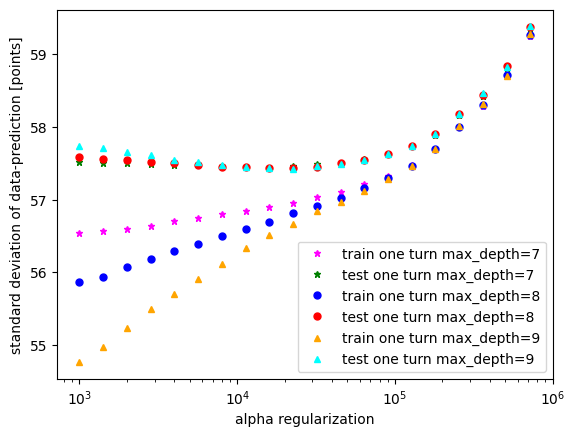

In [16]:
plt.plot(resf[0],resf[2],'*',ms=5,color='magenta',label='train one turn max_depth=7') 
plt.plot(resf[0],resf[3],'*',ms=5,color='green',label='test one turn max_depth=7')
plt.plot(resg[0],resg[2],'o',ms=5,color='blue',label='train one turn max_depth=8') 
plt.plot(resg[0],resg[3],'o',ms=5,color='red',label='test one turn max_depth=8') 
plt.plot(resh[0],resh[2],'^',ms=5,color='orange',label='train one turn max_depth=9') 
plt.plot(resh[0],resh[3],'^',ms=5,color='cyan',label='test one turn max_depth=9') 
plt.legend(loc="best")
plt.xscale("log")
#plt.ylim(55,65)
plt.xlabel("alpha regularization")
plt.ylabel("standard deviation of data-prediction [points]")
print(f"The regularization of the best standard deviation is {resh[0,np.argmin(resh[3])]}")

It is visible in the plot and in the numbers that the model with max depth of 9 is slightly better around the minima for 9. I therefore use the parameters of the best depth 7 models and regenerate it below and save it. 

In [10]:


#excute best model
regxl28=XGBRegressor(max_depth=9,reg_alpha=2.25966826e+04).fit(feature_train, target_train)
#and save it
regxl28.save_model("xgb_model2.json")



The model is then is in the game. 